<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-02-17 

CPython 2.7.10
IPython 5.2.2

numpy 1.12.0
matplotlib 2.0.0
scipy 0.18.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Cosmic-ray composition spectrum analysis
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)
6. [Feature importance](#Feature-importance)

In [2]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [3]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import itertools
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import composition as comp
import composition.analysis.plotting as plotting
    
color_dict = {'light': 'C0', 'heavy': 'C1', 'total': 'C2',
             'P': 'C0', 'He': 'C1', 'O': 'C3', 'Fe':'C4'}

/home/jbourbeau/.virtualenvs/datasci/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
true = [1]*300 + [2]*100
reco = [1]*200 + [2]*100 + [1]*50 + [2]*50
observed = [1]*240 + [2]*158

In [5]:
unfolder = comp.analysis.Unfolder()
unfolder.unfold(true, reco, priors=[0.75, 0.25],
               labels=[1, 2], observed_comp=observed)

240 of label 1
158 of label 2


(array([[ 0.66666667,  0.5       ],
        [ 0.33333333,  0.5       ]]),
 [0.625, 0.375],
 array([[ 0.8       ,  0.66666667],
        [ 0.2       ,  0.33333333]]),
 [297.33333333333331, 100.66666666666666])

# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [4]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [5]:
pipeline_str = 'xgboost'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [6]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [7]:
sim_train, sim_test = comp.preprocess_sim(comp_class=comp_class, return_energy=True)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
             reco_energy_range:  0.654  0.493
                 num_hits_1_30:  0.996  0.493
                max_qfrac_1_30:  0.998  0.493
              InIceQualityCuts:  0.784  0.486




/home/jbourbeau/cr-composition/composition/dataframe_functions.py:124: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_'+i] = np.log10(df['NChannels_'+i])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:125: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_'+i] = np.log10(df['NHits_'+i])


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}(InIce charge (top 50))$
	Charge/NChannels
	NHits/NChannels
	dE/dX (standard)
	
Number training events = 134262
Number testing events = 57541


In [8]:
data = comp.preprocess_data(comp_class=comp_class, return_energy=True)

data quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:    1.0    1.0
             reco_energy_range:    1.0    1.0
                 num_hits_1_30:    1.0    1.0
                max_qfrac_1_30:    1.0    1.0
              InIceQualityCuts:  0.957  0.957


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}(InIce charge (top 50))$
	Charge/NChannels
	NHits/NChannels
	dE/dX (standard)
	
Number testing events = 2124113


Run classifier over training and testing sets to get an idea of the degree of overfitting

In [11]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
pipeline.fit(sim_train.X, sim_train.y)
train_pred = pipeline.predict(sim_train.X)
train_acc = accuracy_score(sim_train.y, train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))
test_pred = pipeline.predict(sim_test.X)
test_acc = accuracy_score(sim_test.y, test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))
print('=' * 30)

XGBClassifier
Training accuracy = 49.98%
Testing accuracy = 48.89%


In [ ]:
print('=' * 30)
print(clf_name)
scores_acc = cross_val_score(estimator=pipeline, X=sim_train.X, y=sim_train.y,
                         scoring='accuracy', cv=3, n_jobs=10)
print('CV accuracy: {:.2%} (+/- {:.2%})'.format(scores_acc.mean(), scores_acc.std()))
print('=' * 30)

In [11]:
print('=' * 30)
print(clf_name)
pipeline.fit(sim_train.X, sim_train.y)
y_pred = pipeline.predict(sim_train.X)
print(classification_report(sim_train.y, y_pred, digits=3))
print('=' * 30)

XGBClassifier
             precision    recall  f1-score   support

          0      0.770     0.789     0.779     66046
          1      0.791     0.771     0.781     68216

avg / total      0.780     0.780     0.780    134262



In [ ]:
print('=' * 30)
print(clf_name)
if comp_class:
    scores_f1 = cross_val_score(estimator=pipeline, X=sim_train.X, y=sim_train.y,
                             scoring='f1', cv=2, n_jobs=10)
    print('CV f1: {:.2%} (+/- {:.2%})'.format(scores_f1.mean(), scores_f1.std()))
else:
    scores_f1 = cross_val_score(estimator=pipeline, X=sim_train.X, y=sim_train.y,
                             scoring='f1', cv=2, n_jobs=10)
    print('CV f1: {:.2%} (+/- {:.2%})'.format(scores_f1.mean(), scores_f1.std()))
print('=' * 30)

XGBClassifier


Process PoolWorker-6:
Process PoolWorker-5:
Process PoolWorker-7:
Process PoolWorker-9:
Process PoolWorker-4:
Process PoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-10:
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiproces

## Fraction correctly identified
[ [back to top](#top) ]

In [9]:
def get_frac_correct(train, test, pipeline, comp_list):
    
    assert isinstance(train, comp.analysis.DataSet), 'train dataset must be a DataSet'
    assert isinstance(test, comp.analysis.DataSet), 'test dataset must be a DataSet'
    assert train.y is not None, 'train must have true y values'
    assert test.y is not None, 'test must have true y values'
    
    pipeline.fit(train.X, train.y)
    test_predictions = pipeline.predict(test.X)
    correctly_identified_mask = (test_predictions == test.y)

    # Construct MC composition masks
    MC_comp_mask = {}
    for composition in comp_list:
        MC_comp_mask[composition] = (test.le.inverse_transform(test.y) == composition)
    MC_comp_mask['total'] = np.array([True]*len(test))
    
    reco_frac, reco_frac_err = {}, {}
    for composition in comp_list+['total']:
        comp_mask = MC_comp_mask[composition]
        # Get number of MC comp in each reco energy bin
        num_MC_energy = np.histogram(test.log_energy[comp_mask],
                                     bins=energybins.log_energy_bins)[0]
        num_MC_energy_err = np.sqrt(num_MC_energy)

        # Get number of correctly identified comp in each reco energy bin
        num_reco_energy = np.histogram(test.log_energy[comp_mask & correctly_identified_mask],
                                       bins=energybins.log_energy_bins)[0]
        num_reco_energy_err = np.sqrt(num_reco_energy)

        # Calculate correctly identified fractions as a function of MC energy
        reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
            num_reco_energy, num_reco_energy_err,
            num_MC_energy, num_MC_energy_err)
    
    return reco_frac, reco_frac_err

### Calculate classifier generalization error via 10-fold CV

In [10]:
# Split training data into CV training and testing folds
kf = KFold(n_splits=10)
frac_correct_folds = defaultdict(list)
fold_num = 0
print('Fold ', end='')
for train_index, test_index in kf.split(sim_train.X):
    fold_num += 1
    print('{}...'.format(fold_num), end='')
    
    reco_frac, reco_frac_err = get_frac_correct(sim_train[train_index],
                                                sim_train[test_index],
                                                pipeline, comp_list)
        
    for composition in comp_list:
        frac_correct_folds[composition].append(reco_frac[composition])
    frac_correct_folds['total'].append(reco_frac['total'])
frac_correct_gen_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}
scores = np.array(frac_correct_folds['total'])
score = scores.mean(axis=1).mean()
score_std = scores.mean(axis=1).std()

Fold 1...2...3...4...5...6...7...8...9...10...

In [11]:
reco_frac, reco_frac_stat_err = get_frac_correct(sim_train, sim_test, pipeline, comp_list)
# step_x = energybins.log_energy_midpoints
# step_x = np.append(step_x[0]-energybins.log_energy_bin_width/2, step_x)
# step_x = np.append(step_x, step_x[-1]+energybins.log_energy_bin_width/2)

/home/jbourbeau/.virtualenvs/datasci/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


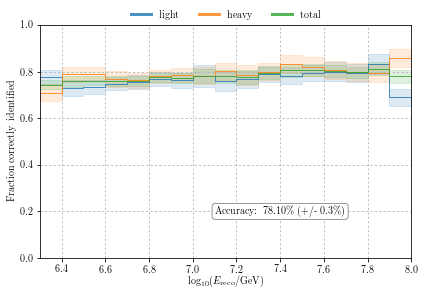

In [12]:
# Plot fraction of events correctlt classified vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_midpoints, reco_frac[composition], err, ax,
                        color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Accuracy: {:0.2f}\% (+/- {:0.1f}\%)'.format(score*100, score_std*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct.png')
plt.show()

## Spectrum
[ [back to top](#top) ]

In [22]:
def get_num_comp_reco(train, test, pipeline, comp_list):
    
    assert isinstance(train, comp.analysis.DataSet), 'train dataset must be a DataSet'
    assert isinstance(test, comp.analysis.DataSet), 'test dataset must be a DataSet'
    assert train.y is not None, 'train must have true y values'
    
    pipeline.fit(train.X, train.y)
    test_predictions = pipeline.predict(test.X)

    # Get number of correctly identified comp in each reco energy bin
    num_reco_energy, num_reco_energy_err = {}, {}
    for composition in comp_list:
        print('composition = {}'.format(composition))
        comp_mask = train.le.inverse_transform(test_predictions) == composition
        print('sum(comp_mask) = {}'.format(np.sum(comp_mask)))
        print(test.log_energy[comp_mask])
        num_reco_energy[composition] = np.histogram(test.log_energy[comp_mask],
            bins=energybins.log_energy_bins)[0]
        num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

    num_reco_energy['total'] = np.histogram(test.log_energy, bins=energybins.log_energy_bins)[0]
    num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])
    
    return num_reco_energy, num_reco_energy_err

In [23]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
             reco_energy_range:  0.654  0.493
                 num_hits_1_30:  0.996  0.493
                max_qfrac_1_30:  0.998  0.493
              InIceQualityCuts:  0.784  0.486




In [24]:
# Get number of events per energy bin
num_reco_energy, num_reco_energy_err = get_num_comp_reco(sim_train, data, pipeline, comp_list)
import pprint
pprint.pprint(num_reco_energy)
# Solid angle
solid_angle = 2*np.pi*(1-np.cos(np.arccos(0.8)))

composition = P
sum(comp_mask) = 610017
[ 6.4142065   6.35758887  6.307427   ...,  6.51546176  6.34287938
  6.30276075]
composition = He
sum(comp_mask) = 414102
[ 6.44164026  6.70570352  6.56144609 ...,  6.3419312   6.58214284
  6.37590079]
composition = O
sum(comp_mask) = 476411
[ 6.37519562  6.42129121  6.37238128 ...,  6.5953384   6.95411459
  6.41366798]
composition = Fe
sum(comp_mask) = 623583
[ 6.5677363   6.39839906  6.62237355 ...,  6.39150733  6.39536296
  6.82679401]
{'Fe': array([167773, 144997, 117998,  67947,  38484,  28615,  17796,  12713,
         9084,   5961,   4065,   2819,   1943,   1433,    911,    626,
          418]),
 'He': array([138662,  88092,  69297,  42963,  28063,  19864,  10701,   6526,
         3345,   2936,   1454,    714,    629,    384,    274,    144,
           54]),
 'O': array([141186, 121274,  62195,  53864,  39839,  21438,  17307,   8735,
         4356,   1821,   1921,   1236,    645,    321,    125,    106,
           42]),
 'P': array([245558, 

In [25]:
print(num_reco_energy['light'].sum())
print(num_reco_energy['heavy'].sum())
frac_light = num_reco_energy['light'].sum()/num_reco_energy['total'].sum()
print(frac_light)

KeyError: 'light'

In [27]:
# Live-time information
goodrunlist = pd.read_table('/data/ana/CosmicRay/IceTop_GRL/IC79_2010_GoodRunInfo_4IceTop.txt', skiprows=[0, 3])
goodrunlist.head()

,RunNum,Good_i3,Good_it,Good_it_L2,LiveTime(s),ActiveStrings,ActiveDoms,ActiveInIceDoms,OutDir,Comment(s)
0,115978,1,1,0,26856,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0531,NaN
1,115982,1,1,1,28548,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0531,NaN
2,115984,1,1,1,6984,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN
3,115985,1,1,1,10476,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN
4,115986,1,1,1,28872,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN


In [28]:
livetimes = goodrunlist['LiveTime(s)']
livetime = np.sum(livetimes[goodrunlist['Good_it_L2'] == 1])
print('livetime (seconds) = {}'.format(livetime))
print('livetime (days) = {}'.format(livetime/(24*60*60)))

livetime (seconds) = 27114012
livetime (days) = 313.819583333


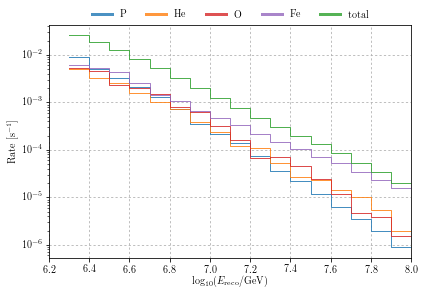

In [30]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy[composition]
    y_err = num_reco_energy_err[composition]
    # Add time duration
    y = y / livetime
    y_err = y / livetime
#     ax.errorbar(log_energy_midpoints, y, yerr=y_err,
#                 color=color_dict[composition], label=composition,
#                 marker='.', linestyle='None')
    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err,
                        ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Rate [s$^{-1}$]')
ax.set_xlim([6.2, 8.0])
# ax.set_ylim([10**2, 10**5])
ax.grid(linestyle=':')
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
plt.show()

In [29]:
eff_area, eff_area_error, energy_midpoints = comp.analysis.get_effective_area(df_sim, energybins.energy_bins)

Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files


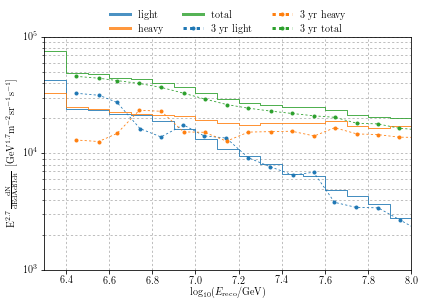

In [40]:
# Plot fraction of events vs energy
# fig, ax = plt.subplots(figsize=(8, 6))
fig = plt.figure()
ax = plt.gca()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy[composition]/energybins.energy_bin_widths
    y_err = num_reco_energy_err[composition]/energybins.energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / livetime
    y_err = y / livetime
    # Add energy scaling 
#     energy_err = get_energy_res(df_sim, energy_bins)
#     energy_err = np.array(energy_err)
#     print(10**energy_err)
    y = energybins.energy_midpoints**2.7 * y
    y_err = energybins.energy_midpoints**2.7 * y_err
#     print(y)
#     print(y_err)
#     ax.errorbar(log_energy_midpoints, y, yerr=y_err, label=composition, color=color_dict[composition],
#            marker='.', markersize=8)
    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
# ax.set_xscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.3, 8])
ax.set_ylim([10**3, 10**5])
ax.grid(linestyle='dotted', which="both")
    
# Add 3-year scraped flux
df_proton = pd.read_csv('3yearscraped/proton', sep='\t', header=None, names=['energy', 'flux'])
df_helium = pd.read_csv('3yearscraped/helium', sep='\t', header=None, names=['energy', 'flux'])
df_light = pd.DataFrame.from_dict({'energy': df_proton.energy, 
                                  'flux': df_proton.flux + df_helium.flux})

df_oxygen = pd.read_csv('3yearscraped/oxygen', sep='\t', header=None, names=['energy', 'flux'])
df_iron = pd.read_csv('3yearscraped/iron', sep='\t', header=None, names=['energy', 'flux'])
df_heavy = pd.DataFrame.from_dict({'energy': df_oxygen.energy, 
                                  'flux': df_oxygen.flux + df_iron.flux})

if comp_class:
    ax.plot(np.log10(df_light.energy), df_light.flux, label='3 yr light',
            marker='.', ls=':')
    ax.plot(np.log10(df_heavy.energy), df_heavy.flux, label='3 yr heavy',
            marker='.', ls=':')
    ax.plot(np.log10(df_heavy.energy), df_heavy.flux+df_light.flux, label='3 yr total',
            marker='.', ls=':')
else:
    ax.plot(np.log10(df_proton.energy), df_proton.flux, label='3 yr proton',
            marker='.', ls=':')
    ax.plot(np.log10(df_helium.energy), df_helium.flux, label='3 yr helium',
            marker='.', ls=':', color=color_dict['He'])
    ax.plot(np.log10(df_oxygen.energy), df_oxygen.flux, label='3 yr oxygen',
            marker='.', ls=':', color=color_dict['O'])
    ax.plot(np.log10(df_iron.energy), df_iron.flux, label='3 yr iron',
        marker='.', ls=':', color=color_dict['Fe'])
    ax.plot(np.log10(df_iron.energy), df_proton.flux+df_helium.flux+df_oxygen.flux+df_iron.flux, label='3 yr total',
    marker='.', ls=':', color='C2')


leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
plt.show()

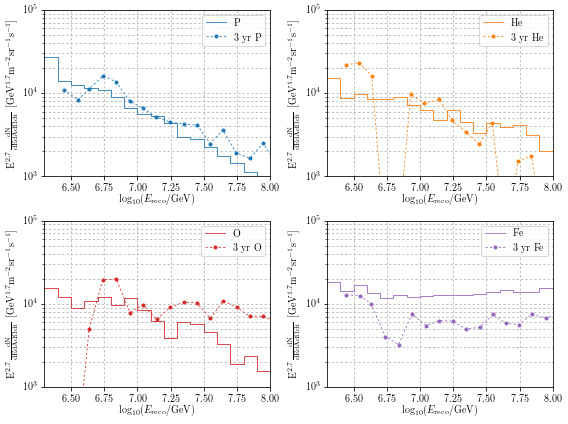

In [31]:
if not comp_class:
    # Add 3-year scraped flux
    df_proton = pd.read_csv('3yearscraped/proton', sep='\t', header=None, names=['energy', 'flux'])
    df_helium = pd.read_csv('3yearscraped/helium', sep='\t', header=None, names=['energy', 'flux'])
    df_oxygen = pd.read_csv('3yearscraped/oxygen', sep='\t', header=None, names=['energy', 'flux'])
    df_iron = pd.read_csv('3yearscraped/iron', sep='\t', header=None, names=['energy', 'flux'])
    # Plot fraction of events vs energy
    fig, axarr = plt.subplots(2, 2, figsize=(8, 6))
    for composition, ax in zip(comp_list + ['total'], axarr.flatten()):
        # Calculate dN/dE
        y = num_reco_energy[composition]/energybins.energy_bin_widths
        y_err = num_reco_energy_err[composition]/energybins.energy_bin_widths
        # Add effective area
        y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
        # Add solid angle
        y = y / solid_angle
        y_err = y_err / solid_angle
        # Add time duration
        y = y / livetime
        y_err = y / livetime
        y = energybins.energy_midpoints**2.7 * y
        y_err = energybins.energy_midpoints**2.7 * y_err
        plotting.plot_steps(energybins.log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
        # Load 3-year flux
        df_3yr = pd.read_csv('3yearscraped/{}'.format(composition), sep='\t',
                             header=None, names=['energy', 'flux'])
        ax.plot(np.log10(df_3yr.energy), df_3yr.flux, label='3 yr {}'.format(composition),
                        marker='.', ls=':', color=color_dict[composition])
        ax.set_yscale("log", nonposy='clip')
        # ax.set_xscale("log", nonposy='clip')
        ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
        ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
        ax.set_xlim([6.3, 8])
        ax.set_ylim([10**3, 10**5])
        ax.grid(linestyle='dotted', which="both")
        ax.legend()

    plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
    plt.show()

## Unfolding
[ [back to top](#top) ]

In [20]:
reco_frac['light']

array([ 0.79794826,  0.76499774,  0.7639696 ,  0.79415557,  0.78565179,
        0.77673225,  0.77012048,  0.78905735,  0.75768668,  0.75121275,
        0.77295025,  0.78764205,  0.79578947,  0.81094527,  0.800269  ,
        0.75702247,  0.67834681])

In [21]:
reco_frac['heavy']

array([ 0.6625555 ,  0.69889899,  0.7124831 ,  0.70190964,  0.68406072,
        0.71247655,  0.71406728,  0.66709677,  0.71340206,  0.71594203,
        0.71060172,  0.7338538 ,  0.73440785,  0.73953824,  0.74112426,
        0.79719298,  0.8142514 ])

In [22]:
num_reco_energy['light']

array([420632, 276894, 181297, 122976,  76838,  47431,  27133,  15700,
         8685,   4821,   2978,   1670,    985,    529,    275,    145,
           72])

In [23]:
num_reco_energy['heavy']

array([325377, 243322, 169803, 107060,  69443,  44516,  29576,  18673,
        12246,   8142,   5537,   3782,   2593,   1804,   1139,    795,
          469])

In [9]:
pipeline.fit(sim_train.X, sim_train.y)
test_predictions = pipeline.predict(sim_test.X)
true_comp = sim_train.le.inverse_transform(sim_train.y)
pred_comp = sim_train.le.inverse_transform(test_predictions)
print(true_comp)
print(pred_comp)

['light' 'light' 'heavy' ..., 'light' 'light' 'heavy']
['light' 'light' 'heavy' ..., 'light' 'heavy' 'light']


In [10]:
unfolder = comp.analysis.Unfolder()
unfolder.unfold(sim_test.y, test_predictions, priors=[0.5, 0.5],
               labels=sim_train.le.transform(comp_list))

array([[ 0.7662391 ,  0.21271109],
       [ 0.2337609 ,  0.78728891]])

In [25]:
bin_idxs = np.digitize(sim_test.log_energy, log_energy_bins) - 1
energy_bin_idx = np.unique(bin_idxs)
energy_bin_idx = energy_bin_idx[1:]
print(energy_bin_idx)
num_reco_energy_unfolded = defaultdict(list)
for bin_idx in energy_bin_idx:
    energy_bin_mask = bin_idxs == bin_idx
    unfolder.unfold()
    confmat = confusion_matrix(true_comp[energy_bin_mask], pred_comp[energy_bin_mask], labels=comp_list)
    confmat = np.divide(confmat.T, confmat.sum(axis=1, dtype=float)).T
    inv_confmat = np.linalg.inv(confmat)
    counts = np.array([num_reco_energy[composition][bin_idx] for composition in comp_list])
    unfolded_counts = np.dot(inv_confmat, counts)
#     unfolded_counts[unfolded_counts < 0] = 0
    num_reco_energy_unfolded['light'].append(unfolded_counts[0])
    num_reco_energy_unfolded['heavy'].append(unfolded_counts[1])
    num_reco_energy_unfolded['total'].append(unfolded_counts.sum())
print(num_reco_energy_unfolded)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
defaultdict(<type 'list'>, {'heavy': [255576.75408727635, 221531.45462754331, 162866.90912554195, 97495.922362062876, 64468.955461737882, 42802.762488527871, 31018.691650927529, 20842.708082768804, 14412.418287669698, 10161.36608962617, 7068.5214392492326, 4859.8624389970428, 3398.4966734468435, 2407.2673761223809, 1552.1352498552965, 1032.8579672669912, 618.70049023115496], 'light': [462426.31324676576, 293901.00833670399, 186991.02456507541, 129580.41406308001, 80212.627964225176, 48761.363425654432, 25973.12833698847, 14325.174113211349, 6853.3328954409008, 3052.3732230850601, 1776.4325056058469, 809.97396820548624, 365.66355205200057, 91.121715996009357, -43.747201014305062, -139.9711100875501, -187.23016622881255], 'total': [718003.06733404216, 515432.46296424733, 349857.93369061733, 227076.33642514289, 144681.58342596306, 91564.12591418231, 56991.819987915995, 35167.882195980157, 21265.751183110599, 13213.73931271123, 8844.9539

In [26]:
unfolded_counts.sum()

431.47032400234241

/home/jbourbeau/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


[ 32964.86466106  27281.60673729  26245.51936798  25800.46976282
  24367.94359577  21912.38305619  17567.46971826  13989.07475035
   9781.68750813   6500.43997616   5592.42691983   3776.25783731
   2593.30366087    948.219778     -677.31023813  -3104.77818648
  -7049.02624428]
[  1.21578705e-03   1.00618111e-03   9.67968863e-04   9.51554855e-04
   8.98721428e-04   8.08157165e-04   6.47911114e-04   5.15935257e-04
   3.60761348e-04   2.39744674e-04   2.06255973e-04   1.39273297e-04
   9.56444093e-05   3.49715777e-05  -2.49800818e-05  -1.14508254e-04
  -2.59977249e-04]
[ 18219.23378418  20563.84242876  22859.52829982  19412.19755384
  19585.14401337  19234.70677643  20980.14221497  20353.69336981
  20570.6878795   21639.99796678  22252.57050605  22657.63387946
  24102.30337491  25050.21456208  24030.72816826  22910.40547222
  23293.44720902]
[ 0.00067195  0.00075842  0.00084309  0.00071595  0.00072233  0.0007094
  0.00077377  0.00075067  0.00075867  0.00079811  0.0008207   0.00083564
  0.

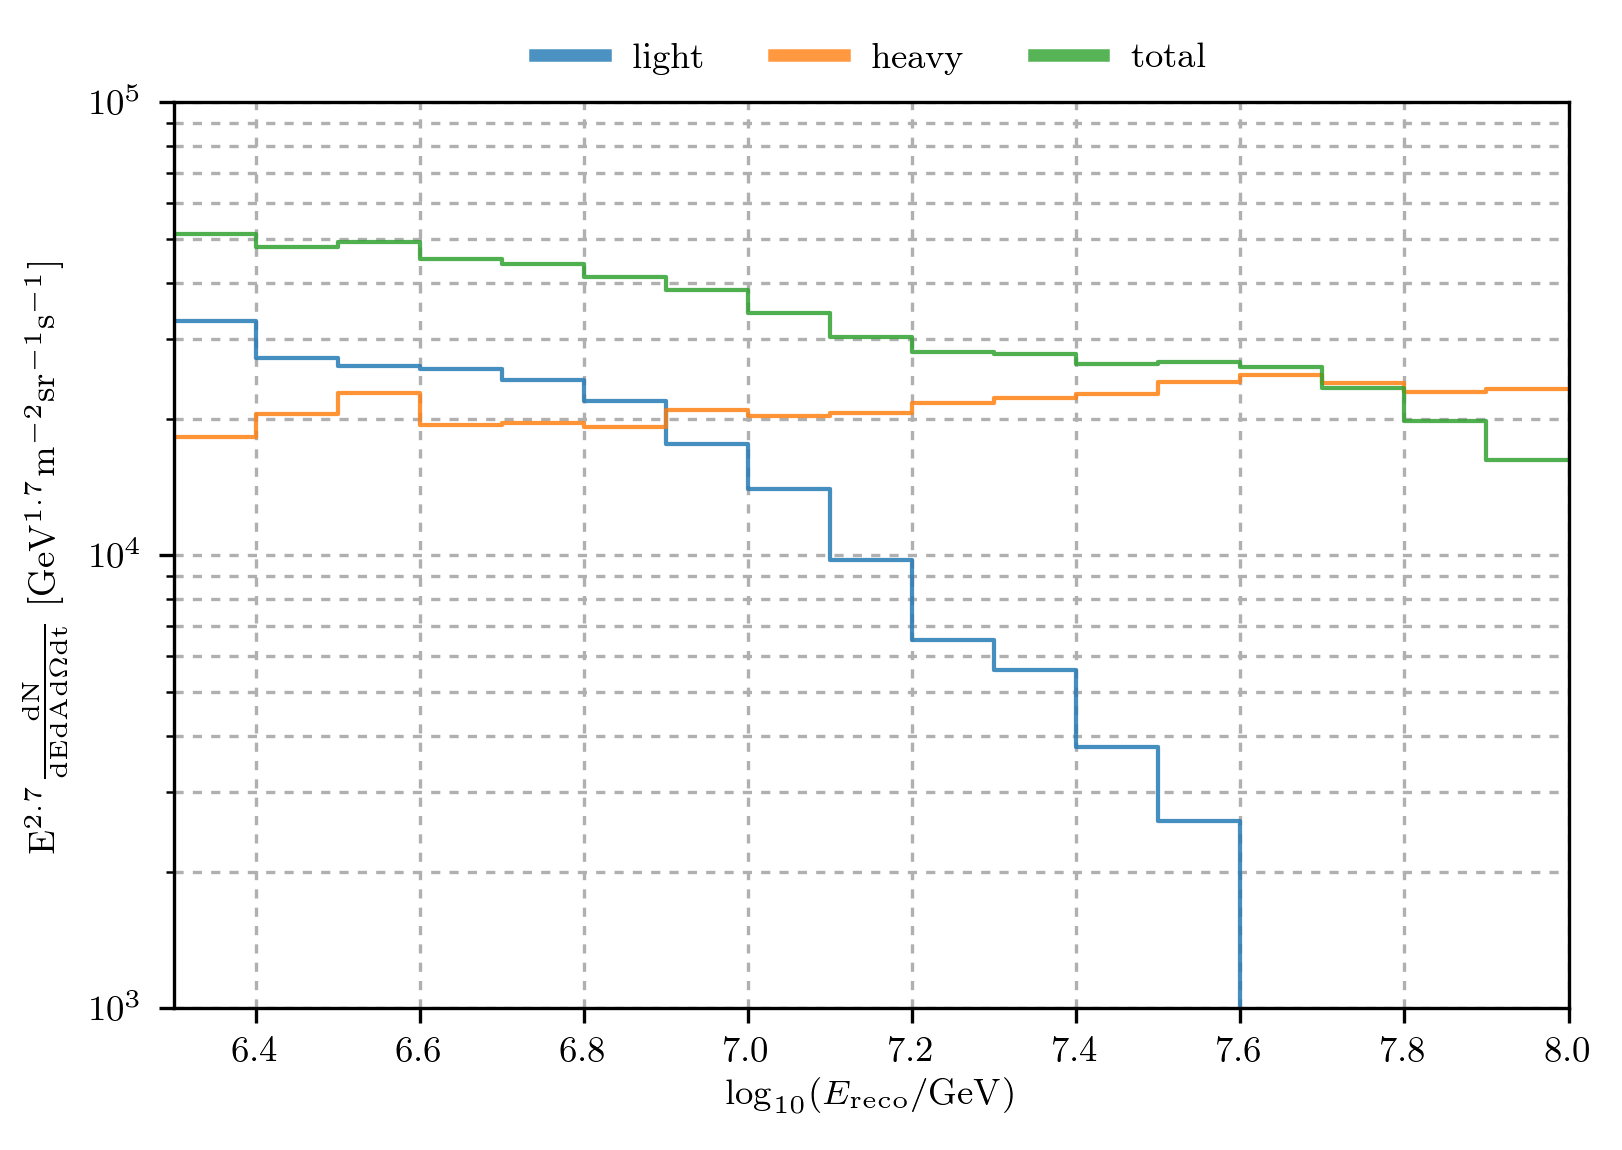

In [27]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy_unfolded[composition]/energy_bin_widths
    y_err = np.sqrt(y)/energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / livetime
    y_err = y / livetime
    # Add energy scaling 
#     energy_err = get_energy_res(df_sim, energy_bins)
#     energy_err = np.array(energy_err)
#     print(10**energy_err)
    y = energy_midpoints**2.7 * y
    y_err = energy_midpoints**2.7 * y_err
    print(y)
    print(y_err)
#     ax.errorbar(log_energy_midpoints, y, yerr=y_err, label=composition, color=color_dict[composition],
#            marker='.', markersize=8)
    plotting.plot_steps(log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
# ax.set_xscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.3, 8])
ax.set_ylim([10**3, 10**5])
ax.grid(linestyle='dotted', which="both")
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
# plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
plt.show()

### Iterative method

Get confusion matrix for each energy bin

In [99]:
bin_idxs = np.digitize(energy_test_sim, log_energy_bins) - 1
energy_bin_idx = np.unique(bin_idxs)
energy_bin_idx = energy_bin_idx[1:]
print(energy_bin_idx)
num_reco_energy_unfolded = defaultdict(list)
response_mat = []
for bin_idx in energy_bin_idx:
    energy_bin_mask = bin_idxs == bin_idx
    confmat = confusion_matrix(true_comp[energy_bin_mask], pred_comp[energy_bin_mask], labels=comp_list)
    confmat = np.divide(confmat.T, confmat.sum(axis=1, dtype=float)).T
    response_mat.append(confmat)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [100]:
response_mat

[array([[ 0.78813559,  0.21186441],
        [ 0.31475086,  0.68524914]]), array([[ 0.7609382 ,  0.2390618 ],
        [ 0.28674007,  0.71325993]]), array([[ 0.7688869 ,  0.2311131 ],
        [ 0.28886886,  0.71113114]]), array([[ 0.7945853 ,  0.2054147 ],
        [ 0.28737774,  0.71262226]]), array([[ 0.77821522,  0.22178478],
        [ 0.29981025,  0.70018975]]), array([[ 0.78485885,  0.21514115],
        [ 0.27861163,  0.72138837]]), array([[ 0.7826506 ,  0.2173494 ],
        [ 0.27828746,  0.72171254]]), array([[ 0.7976269 ,  0.2023731 ],
        [ 0.31419355,  0.68580645]]), array([[ 0.77818448,  0.22181552],
        [ 0.27147766,  0.72852234]]), array([[ 0.77269577,  0.22730423],
        [ 0.26884058,  0.73115942]]), array([[ 0.79117029,  0.20882971],
        [ 0.2786533 ,  0.7213467 ]]), array([[ 0.80965909,  0.19034091],
        [ 0.24698368,  0.75301632]]), array([[ 0.82175439,  0.17824561],
        [ 0.25508059,  0.74491941]]), array([[ 0.8336887 ,  0.1663113 ],
        [ 0.258

In [134]:
r = np.dstack((np.copy(num_reco_energy['light']), np.copy(num_reco_energy['heavy'])))[0]
for unfold_iter in range(50):
    print('Unfolding iteration {}...'.format(unfold_iter))
    if unfold_iter == 0:
        u = r
    fs = []
    for bin_idx in energy_bin_idx:
#         print(u)
        f = np.dot(response_mat[bin_idx], u[bin_idx])
        f[f < 0] = 0
        fs.append(f)
#         print(f)
    u = u + (r - fs)
#     u[u < 0] = 0
#     print(u)
unfolded_counts_iter = {}
unfolded_counts_iter['light'] = u[:,0]
unfolded_counts_iter['heavy'] = u[:,1]
unfolded_counts_iter['total'] = u.sum(axis=1)
print(unfolded_counts_iter)

Unfolding iteration 0...
Unfolding iteration 1...
Unfolding iteration 2...
Unfolding iteration 3...
Unfolding iteration 4...
Unfolding iteration 5...
Unfolding iteration 6...
Unfolding iteration 7...
Unfolding iteration 8...
Unfolding iteration 9...
Unfolding iteration 10...
Unfolding iteration 11...
Unfolding iteration 12...
Unfolding iteration 13...
Unfolding iteration 14...
Unfolding iteration 15...
Unfolding iteration 16...
Unfolding iteration 17...
Unfolding iteration 18...
Unfolding iteration 19...
Unfolding iteration 20...
Unfolding iteration 21...
Unfolding iteration 22...
Unfolding iteration 23...
Unfolding iteration 24...
Unfolding iteration 25...
Unfolding iteration 26...
Unfolding iteration 27...
Unfolding iteration 28...
Unfolding iteration 29...
Unfolding iteration 30...
Unfolding iteration 31...
Unfolding iteration 32...
Unfolding iteration 33...
Unfolding iteration 34...
Unfolding iteration 35...
Unfolding iteration 36...
Unfolding iteration 37...
Unfolding iteration 38

/home/jbourbeau/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


[ 30608.90300256  25739.19353959  26090.26032924  24994.4368117
  22855.5941019   20394.79482403  16744.52586455  12750.96672149
   8963.77697026   6521.34060238   5355.5471064    3821.85911214
   3190.60289416   1505.68516182    435.52646429  -1382.82112343
  -3470.66606373]
[  1.12889612e-03   9.49294908e-04   9.62242708e-04   9.21827312e-04
   8.42944014e-04   7.52186538e-04   6.17559875e-04   4.70272224e-04
   3.30595744e-04   2.40515517e-04   1.97519537e-04   1.40955131e-04
   1.17673581e-04   5.55316256e-05   1.60627820e-05  -5.10002401e-05
  -1.28002675e-04]
[ 21649.88554024  22390.63811411  23011.29201211  20433.71168285
  21475.71774523  20960.24006155  21927.64402967  21830.88988231
  21535.1321382   21716.25553755  22658.89678563  22663.68989536
  23765.62834405  24926.04108309  23537.56085353  22789.89776587
  23081.42094915]
[ 0.00079848  0.0008258   0.00084869  0.00075362  0.00079205  0.00077304
  0.00080872  0.00080515  0.00079424  0.00080092  0.00083569  0.00083587
  0.

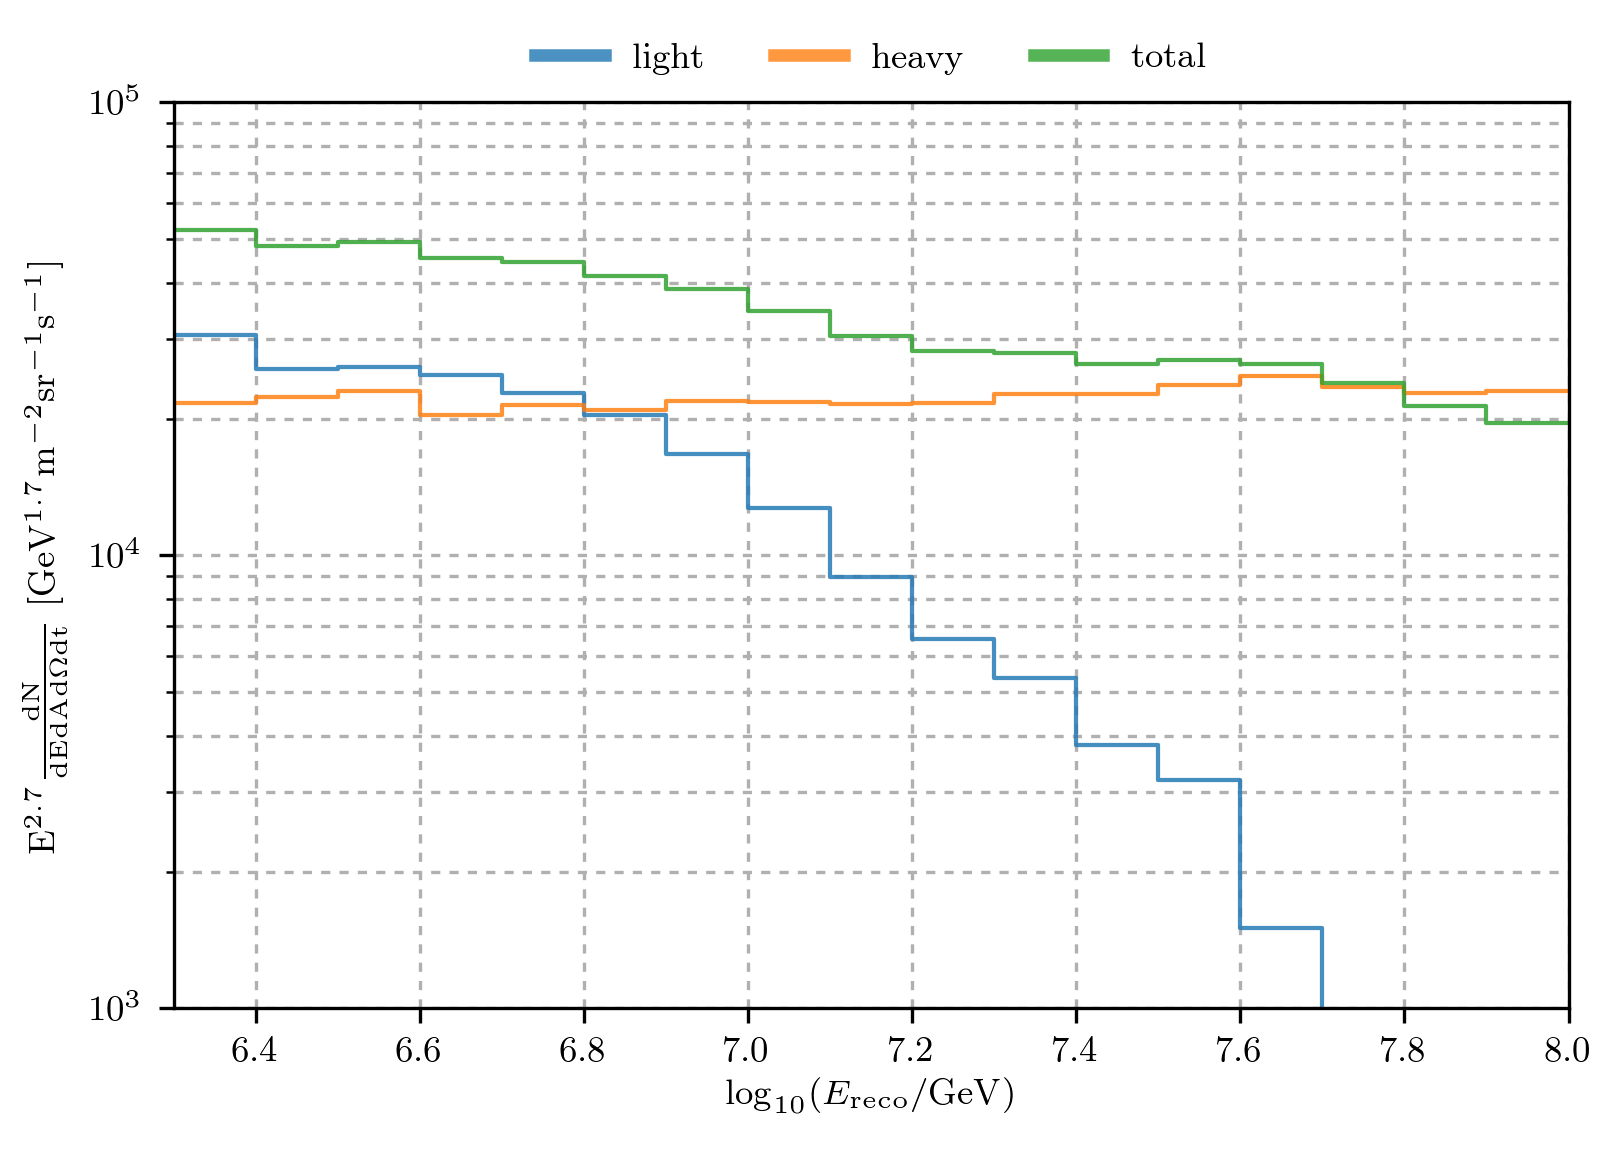

In [135]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = unfolded_counts_iter[composition]/energy_bin_widths
    y_err = np.sqrt(y)/energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / livetime
    y_err = y / livetime
    # Add energy scaling 
#     energy_err = get_energy_res(df_sim, energy_bins)
#     energy_err = np.array(energy_err)
#     print(10**energy_err)
    y = energy_midpoints**2.7 * y
    y_err = energy_midpoints**2.7 * y_err
    print(y)
    print(y_err)
#     ax.errorbar(log_energy_midpoints, y, yerr=y_err, label=composition, color=color_dict[composition],
#            marker='.', markersize=8)
    plotting.plot_steps(log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
# ax.set_xscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.3, 8])
ax.set_ylim([10**3, 10**5])
ax.grid(linestyle='dotted', which="both")
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
# plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
plt.show()

In [106]:
print(num_reco_energy)

{'heavy': array([343258, 251555, 170285, 109209,  72054,  46292,  30287,  19434,
        12697,   8279,   5666,   3863,   2611,   1814,   1134,    785,
          464]), 'light': array([402751, 268661, 180815, 120827,  74227,  45655,  26422,  14939,
         8234,   4684,   2849,   1589,    967,    519,    280,    155,
           77]), 'total': array([746009, 520216, 351100, 230036, 146281,  91947,  56709,  34373,
        20931,  12963,   8515,   5452,   3578,   2333,   1414,    940,
          541])}


Normalized confusion matrix
[[ 0.77924806  0.22075194]
 [ 0.31332376  0.68667624]]


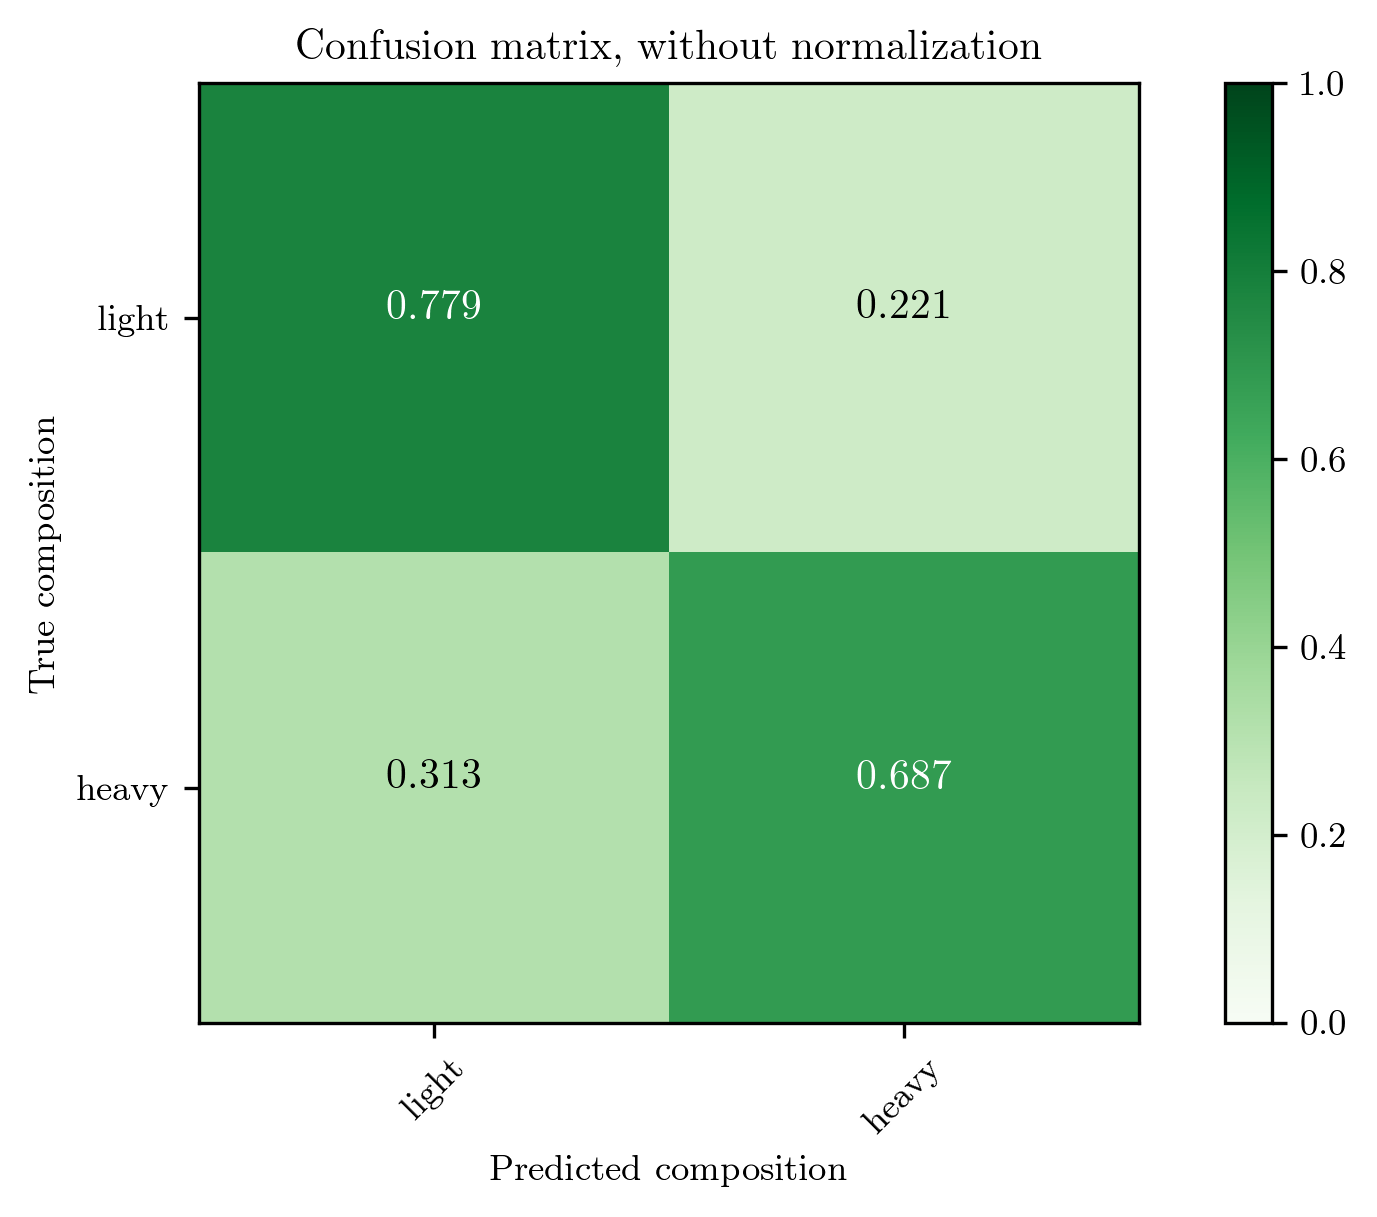

In [107]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
test_predictions = pipeline.predict(X_test_sim)
# correctly_identified_mask = (test_predictions == y_test)
# confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)/len(y_pred)
true_comp = le.inverse_transform(y_test_sim)
pred_comp = le.inverse_transform(test_predictions)
confmat = confusion_matrix(true_comp, pred_comp, labels=comp_list)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='None', cmap=cmap,
               vmin=0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:0.3f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True composition')
    plt.xlabel('Predicted composition')

fig, ax = plt.subplots()
plot_confusion_matrix(confmat, classes=['light', 'heavy'], normalize=True,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [63]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
test_predictions = pipeline.predict(X_test_sim)
# correctly_identified_mask = (test_predictions == y_test)
# confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)/len(y_pred)
true_comp = le.inverse_transform(y_test_sim)
pred_comp = le.inverse_transform(test_predictions)
confmat = confusion_matrix(true_comp, pred_comp, labels=comp_list)

inverse = np.linalg.inv(confmat)
inverse

array([[  4.65885e-05,  -1.58473e-05],
       [ -1.80751e-05,   5.14300e-05]])

In [64]:
confmat

array([[24379,  7512],
       [ 8568, 22084]])

0.942477796077
1.46998611753
1409662.44128
[[  1.09286e+00   4.25348e-01]
 [  6.78230e-01   4.21116e-01]
 [  3.64535e-01   4.12274e-01]
 [  2.15254e-01   3.05955e-01]
 [  1.50773e-01   1.80818e-01]
 [  9.30369e-02   1.16594e-01]
 [  6.14838e-02   6.87016e-02]
 [  2.92043e-02   5.37845e-02]
 [  1.02666e-02   4.00306e-02]
 [  2.43373e-03   2.84436e-02]
 [  4.68133e-03   1.48927e-02]
 [  1.87090e-03   1.15002e-02]
 [ -6.73351e-04   9.90623e-03]
 [ -2.40343e-04   5.57233e-03]
 [ -2.92290e-04   4.14347e-03]
 [ -1.09387e-04   2.35180e-03]
 [ -2.28537e-04   1.67352e-03]
 [ -9.98517e-05   9.89654e-04]]
[[  1.09286e+00   4.25348e-01]
 [  6.78230e-01   4.21116e-01]
 [  3.64535e-01   4.12274e-01]
 [  2.15254e-01   3.05955e-01]
 [  1.50773e-01   1.80818e-01]
 [  9.30369e-02   1.16594e-01]
 [  6.14838e-02   6.87016e-02]
 [  2.92043e-02   5.37845e-02]
 [  1.02666e-02   4.00306e-02]
 [  2.43373e-03   2.84436e-02]
 [  4.68133e-03   1.48927e-02]
 [  1.87090e-03   1.15002e-02]
 [ -6.73351e-04   9.90623e

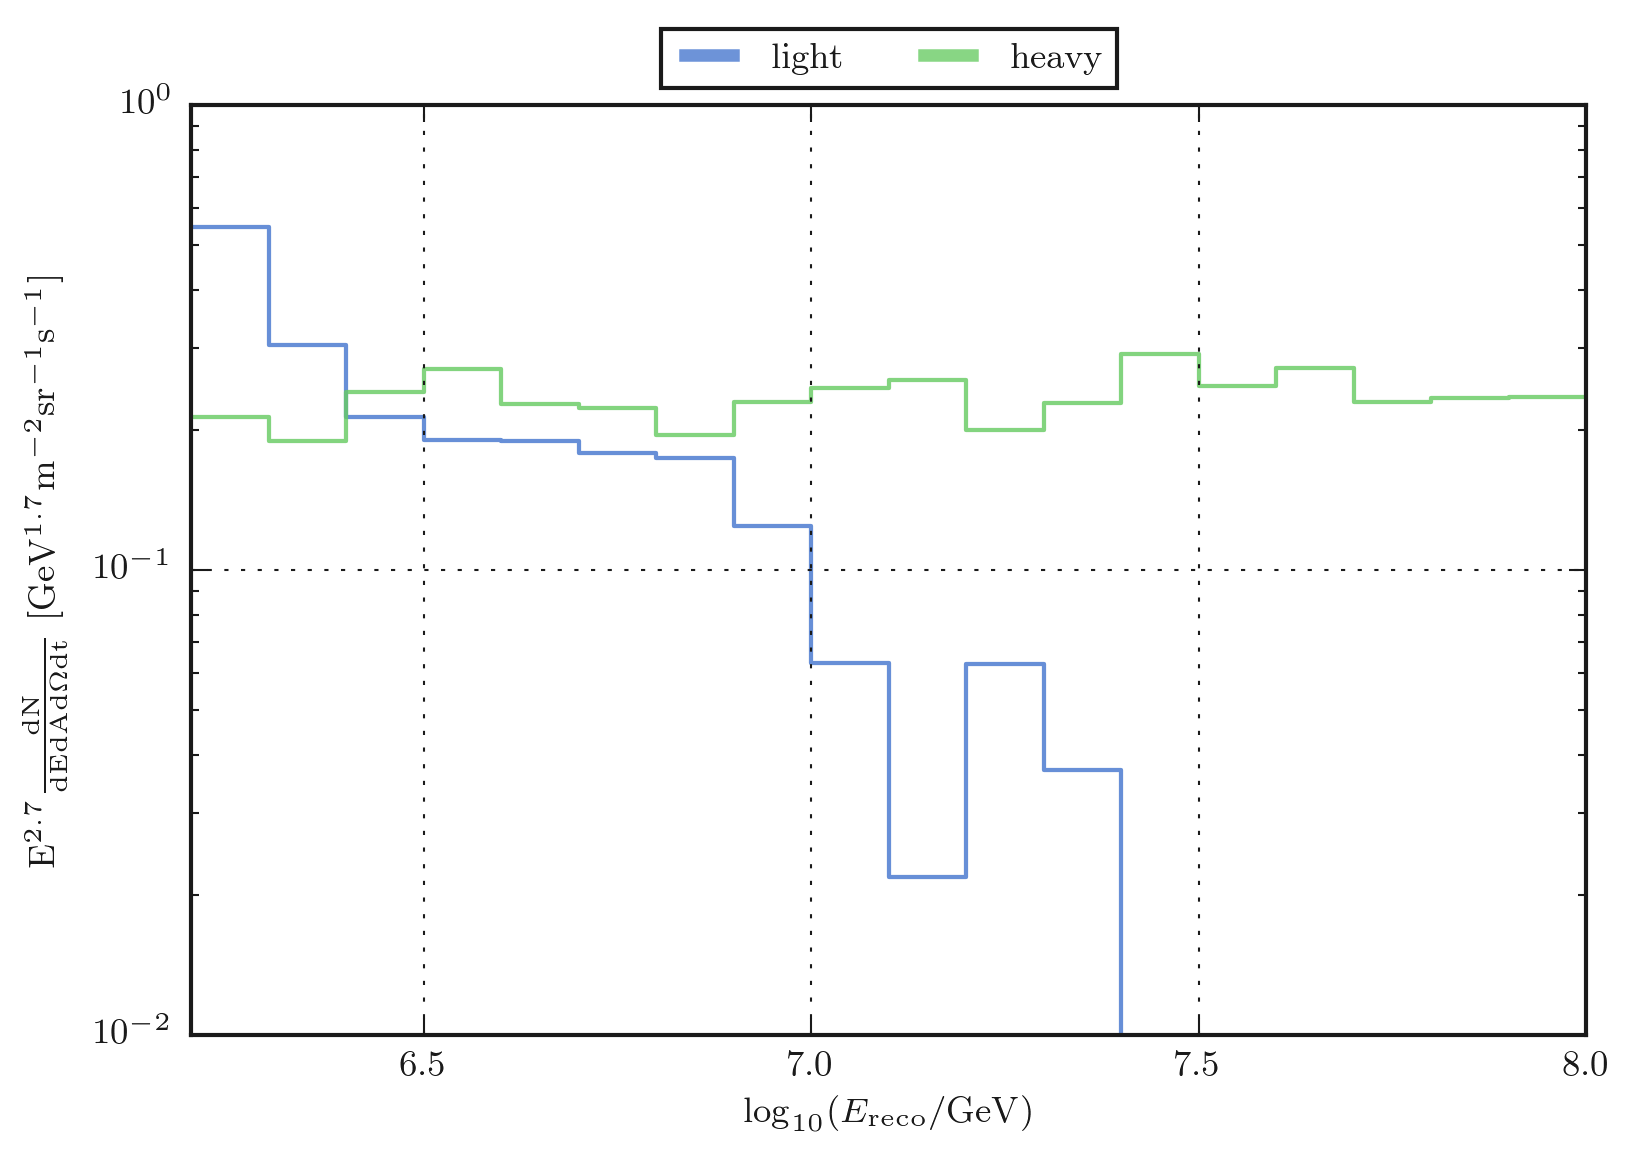

In [66]:
comp_list = ['light', 'heavy']
# Get number of events per energy bin
num_reco_energy, num_reco_energy_err = get_num_comp_reco(X_train_sim, y_train_sim, X_test_data, comp_list)
# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
energy_bin_widths = 10**energy_bins[1:] - 10**energy_bins[:-1]
def get_energy_res(df_sim, energy_bins):
    reco_log_energy = df_sim['lap_log_energy'].values 
    MC_log_energy = df_sim['MC_log_energy'].values
    energy_res = reco_log_energy - MC_log_energy
    bin_centers, bin_medians, energy_err = comp.analysis.data_functions.get_medians(reco_log_energy,
                                                                               energy_res,
                                                                               energy_bins)
    return np.abs(bin_medians)
# Solid angle
solid_angle = 2*np.pi*(1-np.cos(np.arccos(0.85)))
# solid_angle = 2*np.pi*(1-np.cos(40*(np.pi/180)))
print(solid_angle)
print(2*np.pi*(1-np.cos(40*(np.pi/180))))
# Live-time information
start_time = np.amin(df_data['start_time_mjd'].values)
end_time = np.amax(df_data['end_time_mjd'].values)
day_to_sec = 24 * 60 * 60.
dt = day_to_sec * (end_time - start_time)
print(dt)
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for i, composition in enumerate(comp_list):
    num_reco_bin = np.array([[i, j] for i, j in zip(num_reco_energy['light'], num_reco_energy['heavy'])])
#     print(num_reco_bin)
    num_reco = np.array([np.dot(inverse, i) for i in num_reco_bin])
    print(num_reco)
    num_reco_2 = {'light': num_reco[:, 0], 'heavy': num_reco[:, 1]}
    # Calculate dN/dE
    y = num_reco_2[composition]/energy_bin_widths
    y_err = num_reco_energy_err[composition]/energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / dt
    y_err = y / dt
    # Add energy scaling 
    energy_err = get_energy_res(df_sim, energy_bins)
    energy_err = np.array(energy_err)
#     print(10**energy_err)
    y = (10**energy_midpoints)**2.7 * y
    y_err = (10**energy_midpoints)**2.7 * y_err
    plotting.plot_steps(energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.2, 8.0])
# ax.set_ylim([10**2, 10**5])
ax.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
plt.show()

In [44]:
pipeline.get_params()['classifier__max_depth']

6

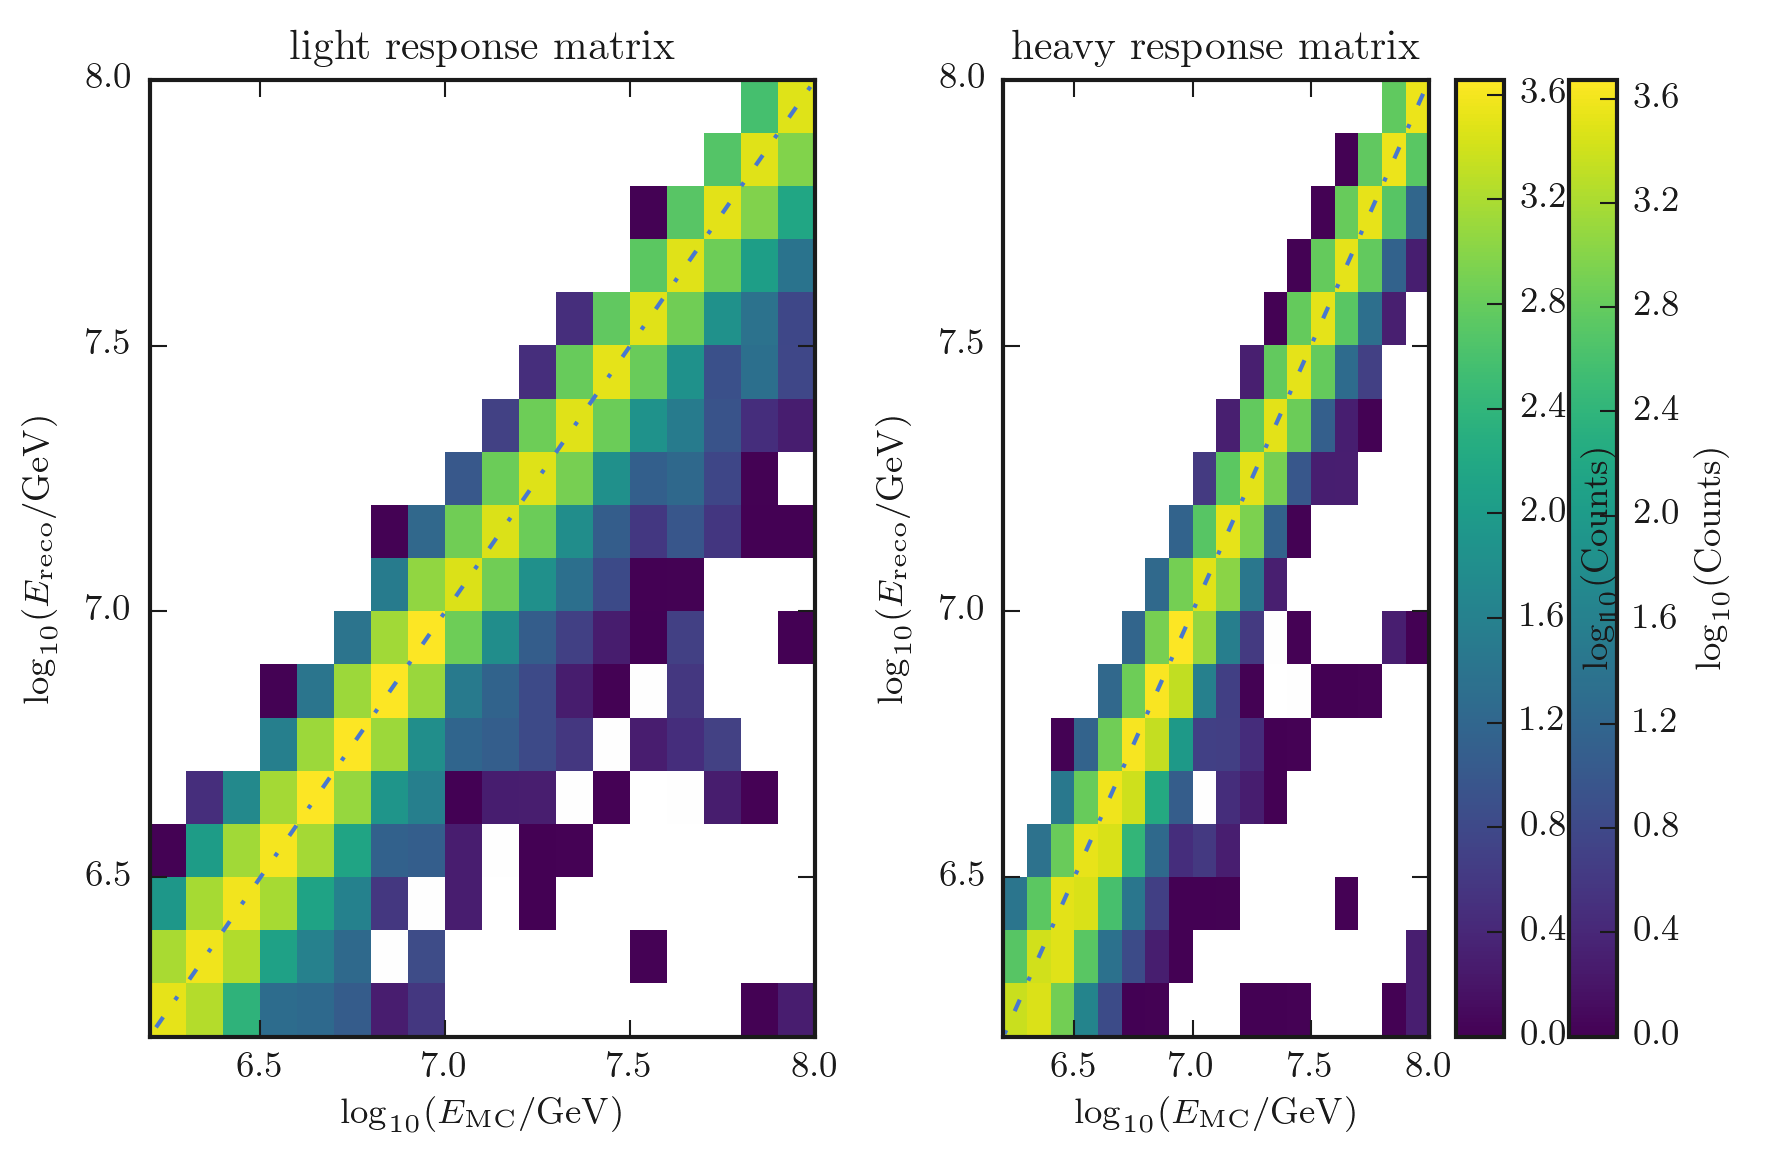

In [47]:
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
fig, axarr = plt.subplots(1, 2)
for composition, ax in zip(comp_list, axarr.flatten()):
    MC_comp_mask = (df_sim['MC_comp_class'] == composition)
    MC_log_energy = df_sim['MC_log_energy'][MC_comp_mask].values
    reco_log_energy = df_sim['lap_log_energy'][MC_comp_mask].values
    plotting.histogram_2D(MC_log_energy, reco_log_energy, energy_bins, log_counts=True, ax=ax)
    ax.plot([0,10], [0,10], marker='None', linestyle='-.')
    ax.set_xlim([6.2, 8])
    ax.set_ylim([6.2, 8])
    ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
    ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
    ax.set_title('{} response matrix'.format(composition))
plt.tight_layout()
plt.show()

In [10]:
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
10**energy_bins[1:] - 10**energy_bins[:-1]

array([   410369.12250776,    516624.1165407 ,    650391.2286588 ,
          818794.04536659,   1030800.63073774,   1297701.1085292 ,
         1633708.90244087,   2056717.65275717,   2589254.11794165,
         3259677.80666943,   4103691.22507761,   5166241.16540694,
         6503912.28658791,   8187940.45366581,  10308006.30737735,
        12977011.08529189,  16337089.02440856,  20567176.52757148])

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)

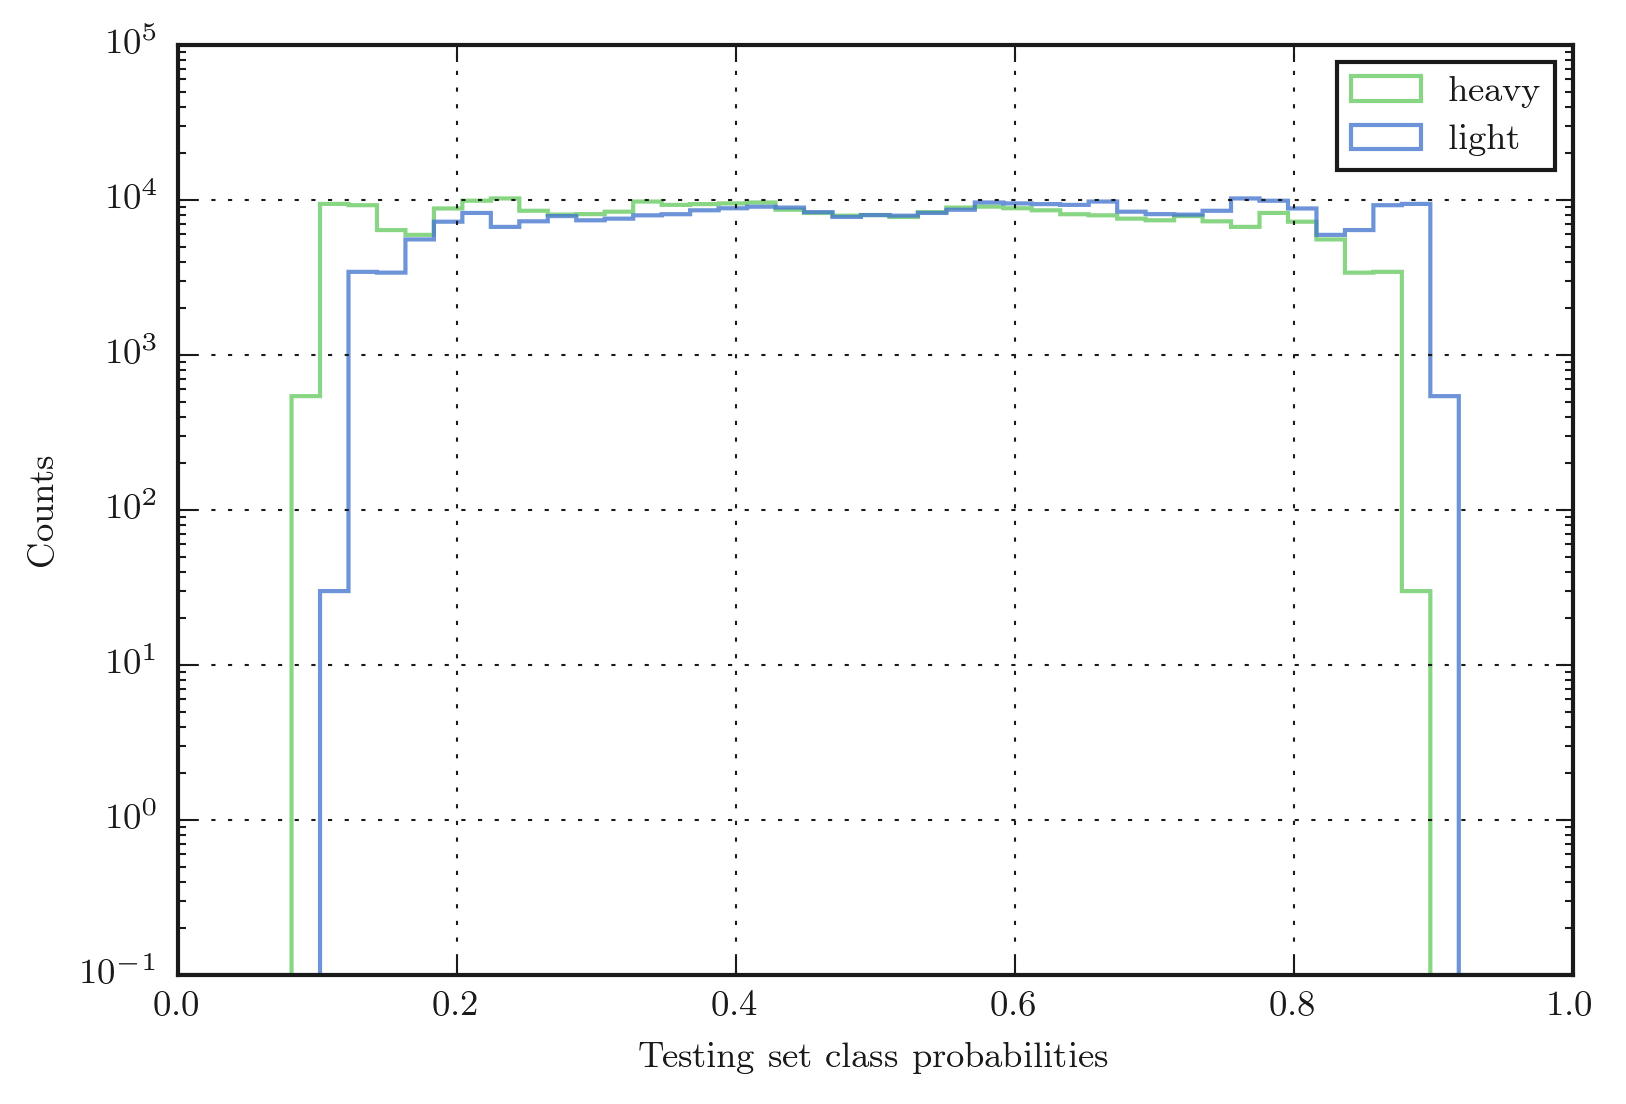

In [48]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
# test_probs = defaultdict(list)
fig, ax = plt.subplots()
test_predictions = pipeline.predict(X_test_data)
test_probs = pipeline.predict_proba(X_test_data)
for class_ in pipeline.classes_:
    test_predictions == le.inverse_transform(class_)
    plt.hist(test_probs[:, class_], bins=np.linspace(0, 1, 50),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend()
plt.grid()
plt.show()

probs = (15883, 4)
min = 1.38011981318
max = 3.56902754108
probs = (15920, 4)
min = 1.40518894839
max = 3.5562126663
probs = (15507, 4)
min = 1.45593414673
max = 3.57278805564
probs = (15066, 4)
min = 1.50426220527
max = 3.60566706999


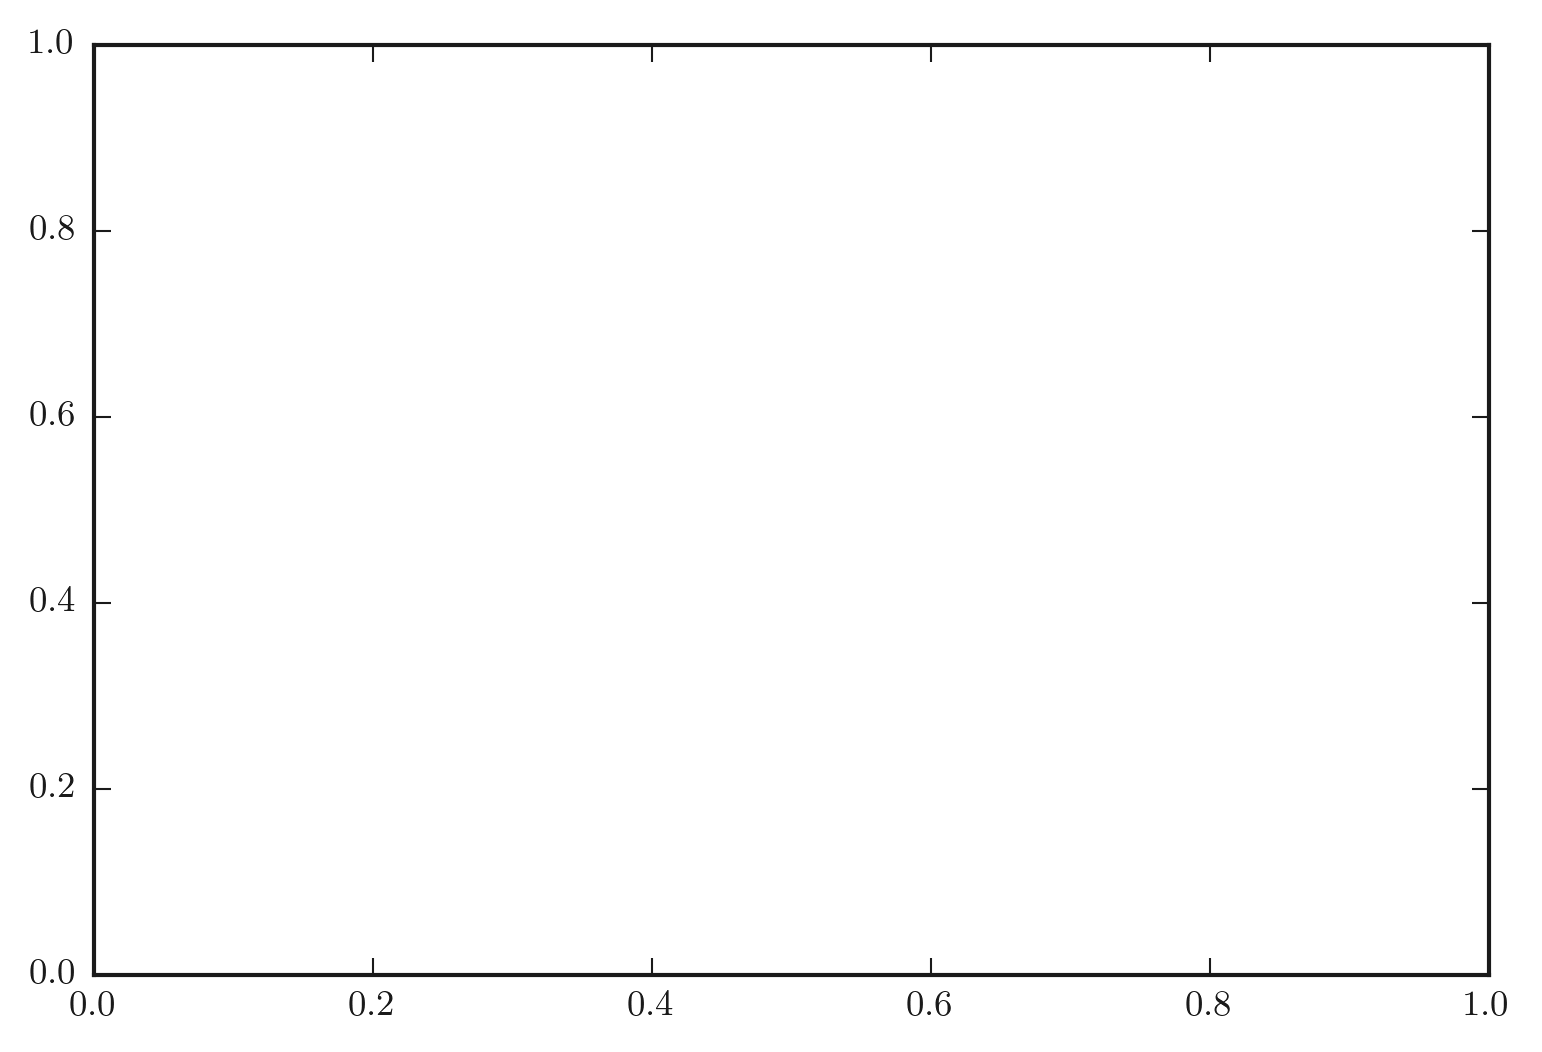

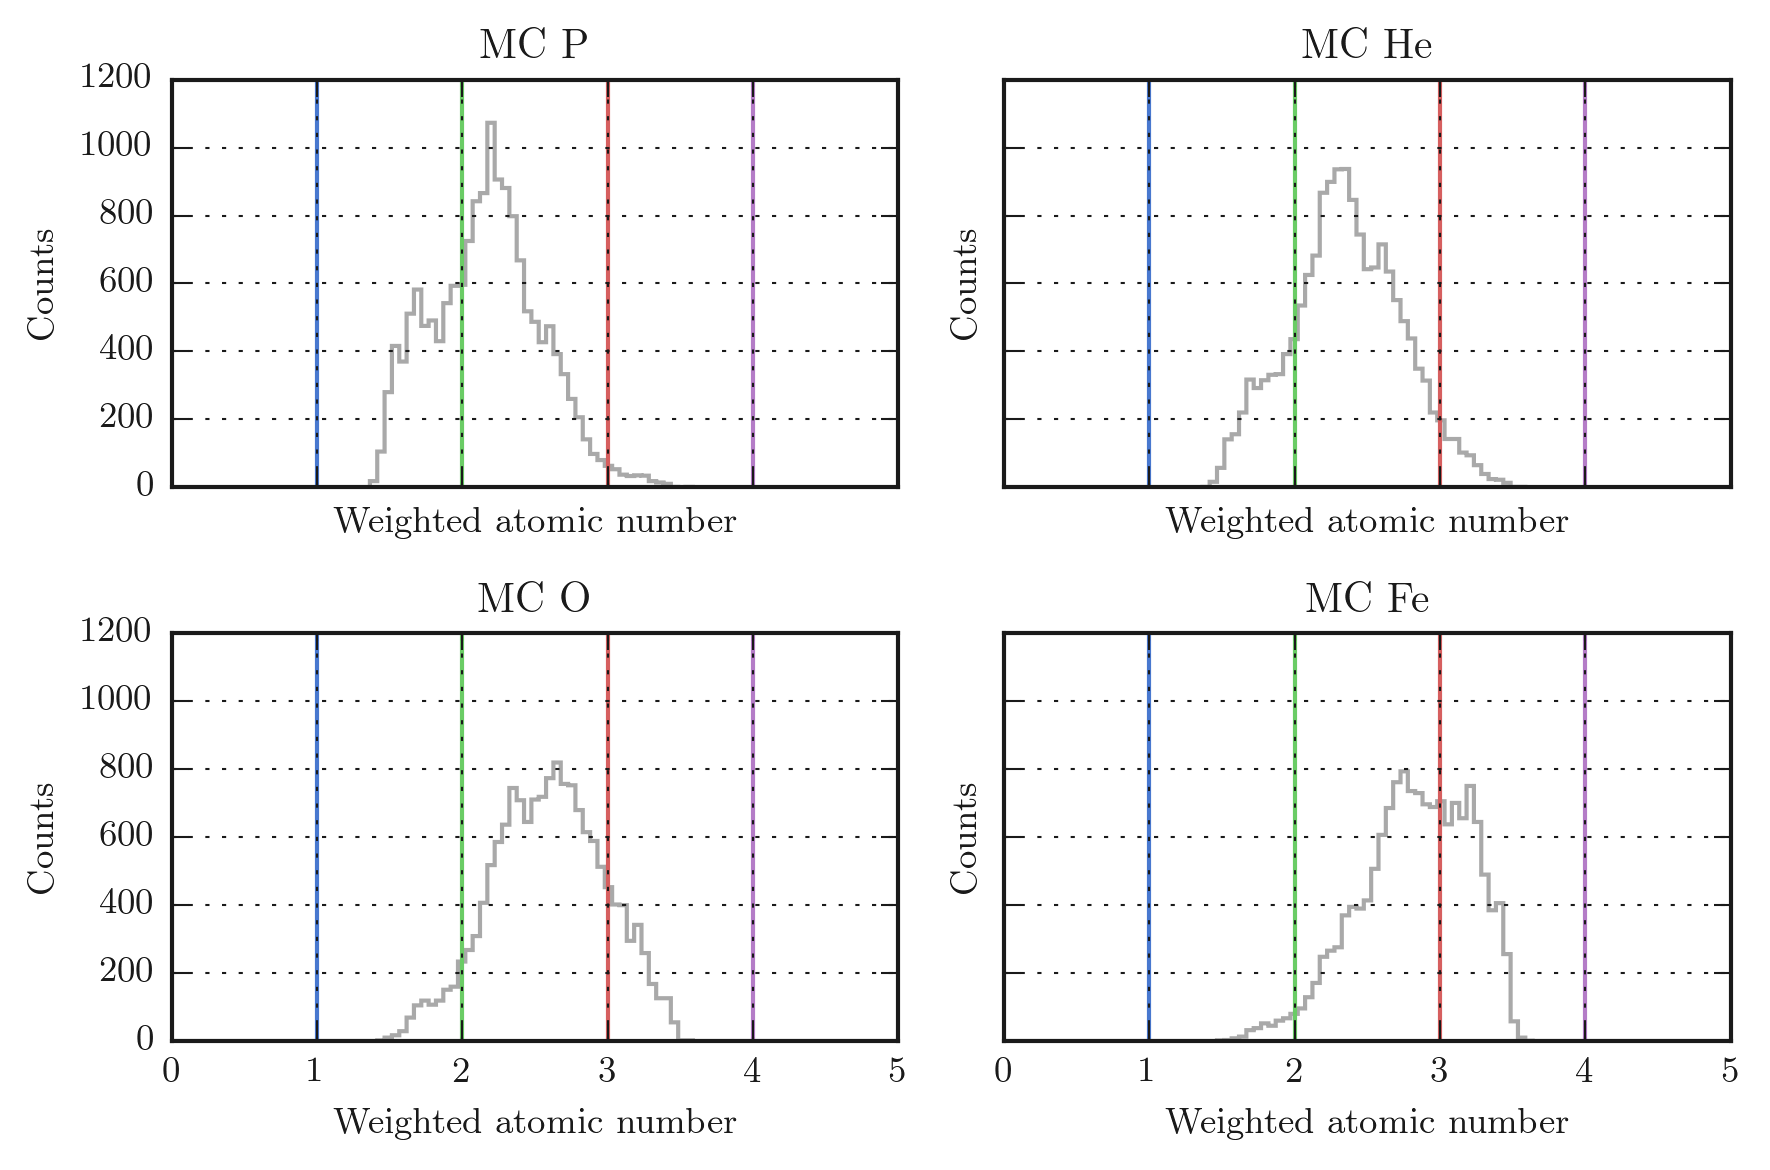

In [5]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    print('probs = {}'.format(probs.shape))
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        weighted_mass += comp.simfunctions.comp2mass(c) * probs[:, class_]
    print('min = {}'.format(min(weighted_mass)))
    print('max = {}'.format(max(weighted_mass)))
    ax.hist(weighted_mass, bins=np.linspace(0, 5, 100),
             histtype='step', label=None, color='darkgray',
             alpha=1.0, log=False)
    for c in comp_list:
        ax.axvline(comp.simfunctions.comp2mass(c), color=color_dict[c],
                   marker='None', linestyle='-')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Weighted atomic number')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

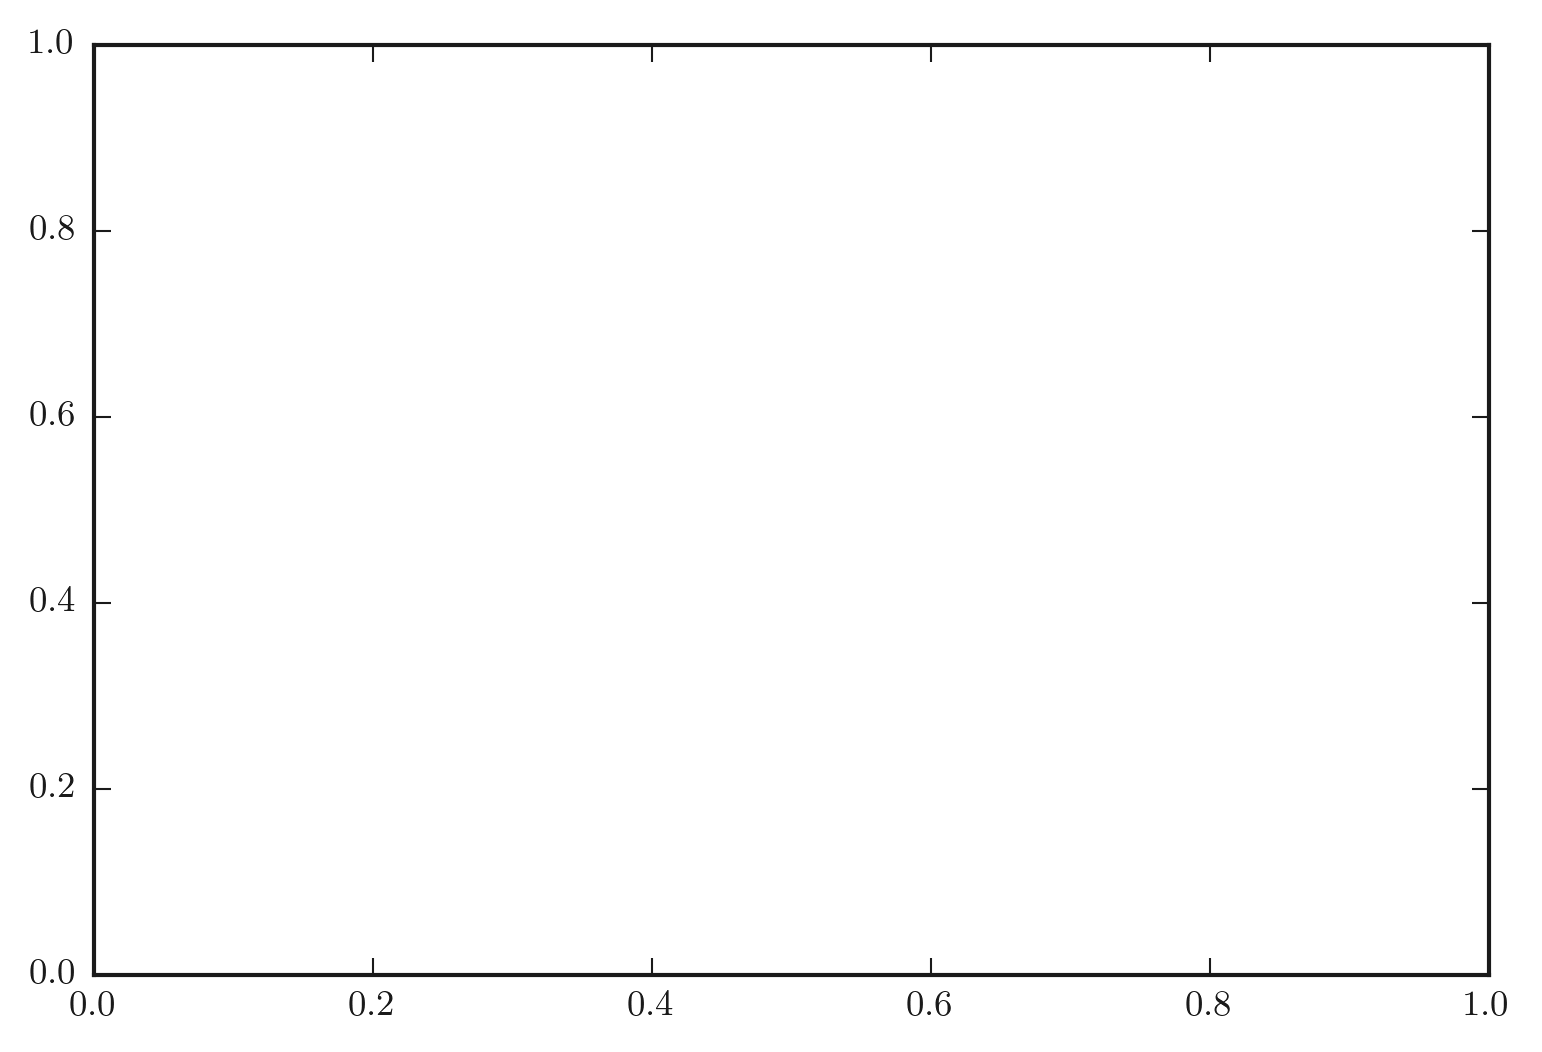

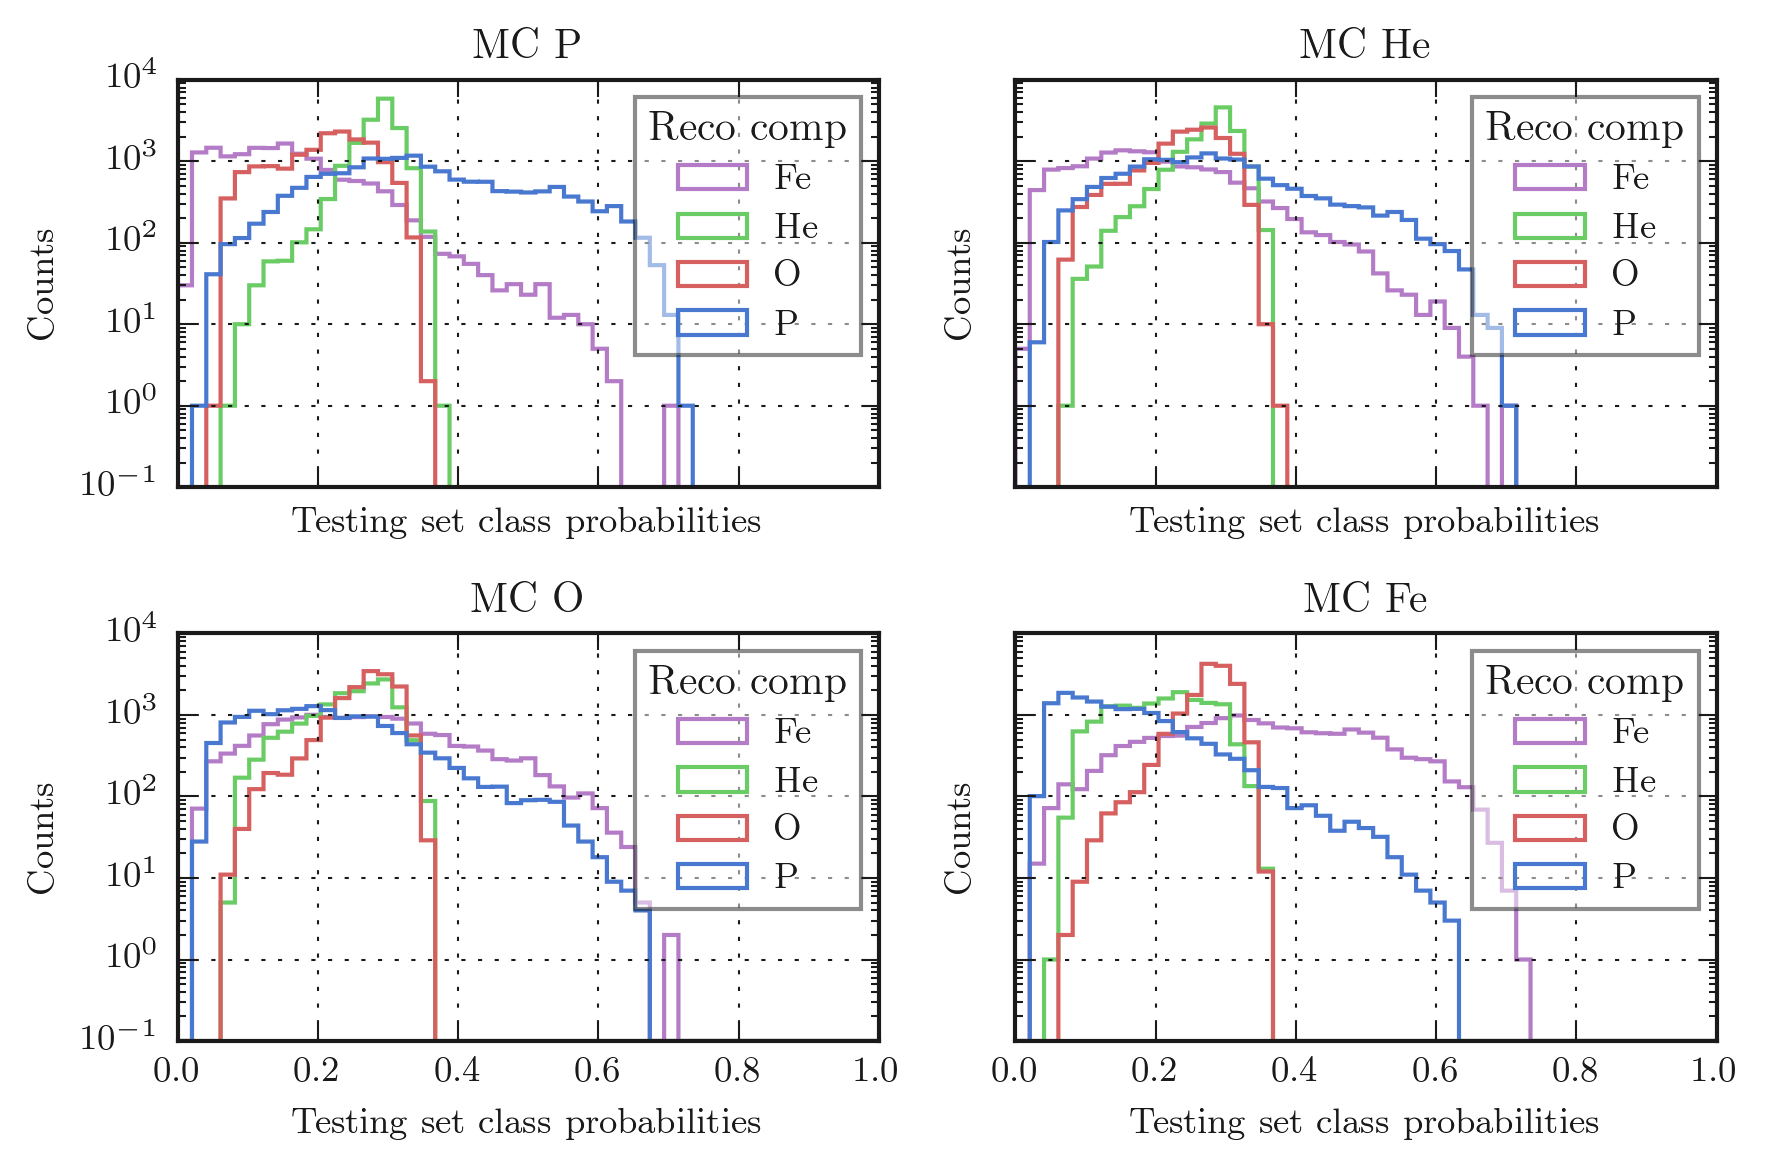

In [15]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        ax.hist(probs[:, class_], bins=np.linspace(0, 1, 50),
                 histtype='step', label=c, color=color_dict[c],
                 alpha=1.0, log=True)
    ax.legend(title='Reco comp', framealpha=0.5)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Testing set class probabilities')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

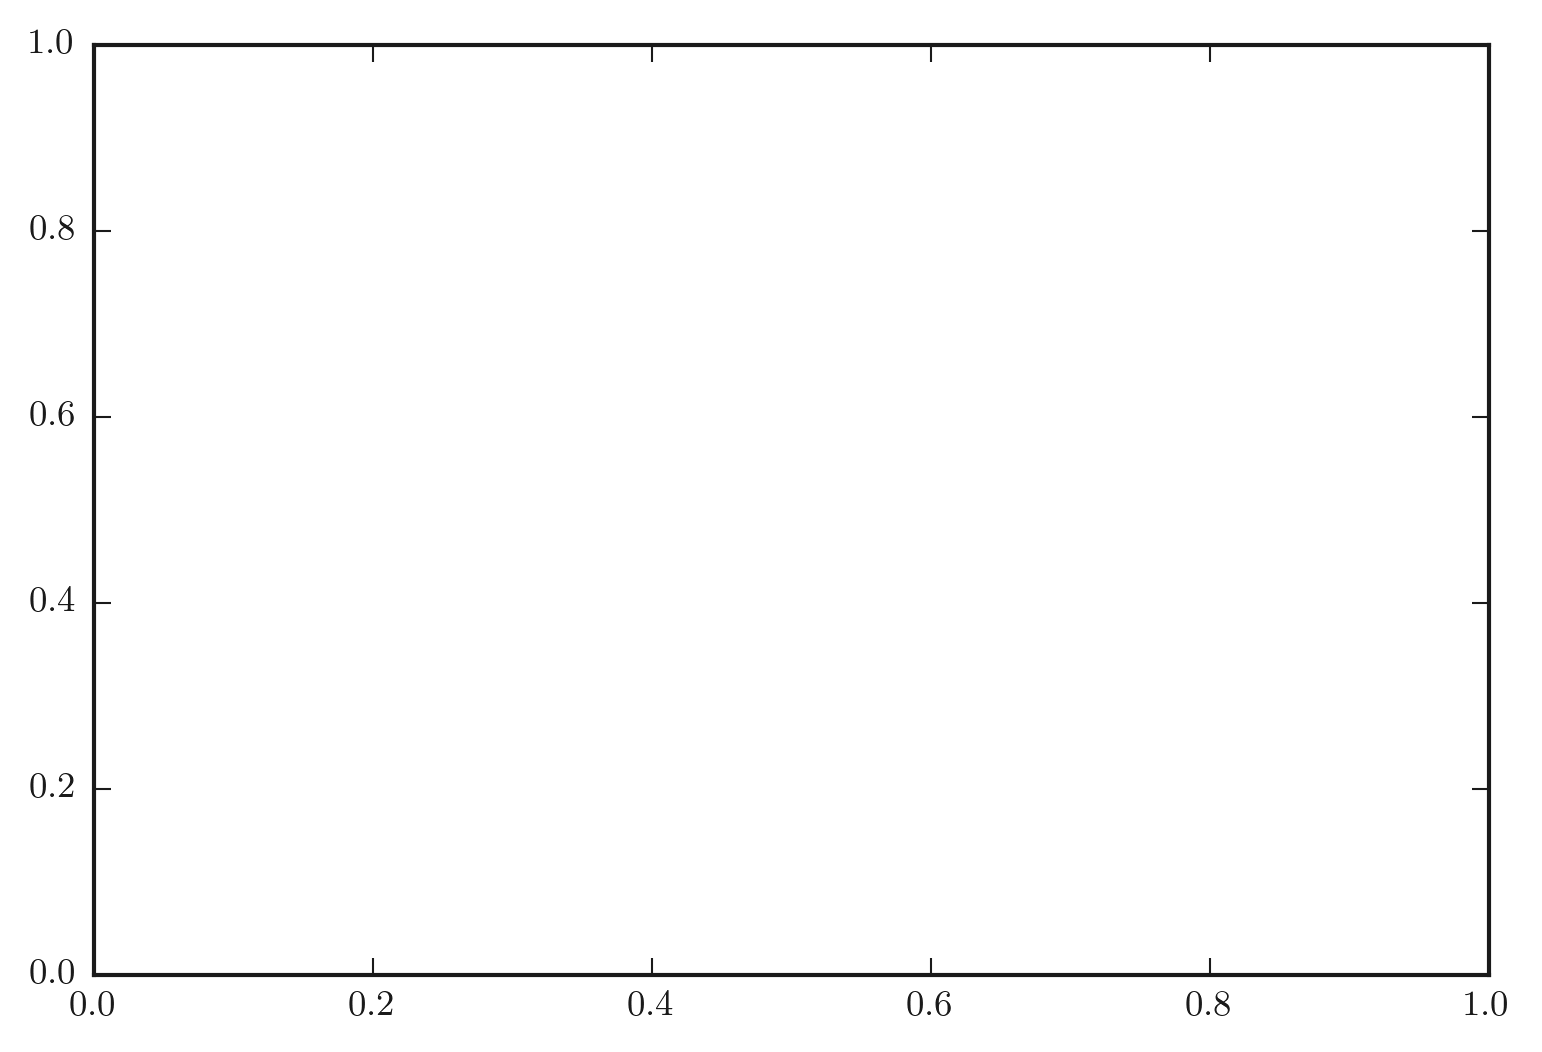

In [25]:
comp_list = ['light', 'heavy']
test_probs = defaultdict(list)
fig, ax = plt.subplots()
# test_probs = pipeline.predict_proba(X_test)
for event in pipeline.predict_proba(X_test_data):
    composition = le.inverse_transform(np.argmax(event))
    test_probs[composition].append(np.amax(event))
for composition in comp_list:
    plt.hist(test_probs[composition], bins=np.linspace(0, 1, 100),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=False)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend(title='Reco comp')
plt.grid()
plt.show()